# Preliminary Exploration

## White noise

White noise is random, but characterized by a Gaussian distribution about a mean. Plotting white noise as a histogram reveals this behavior:

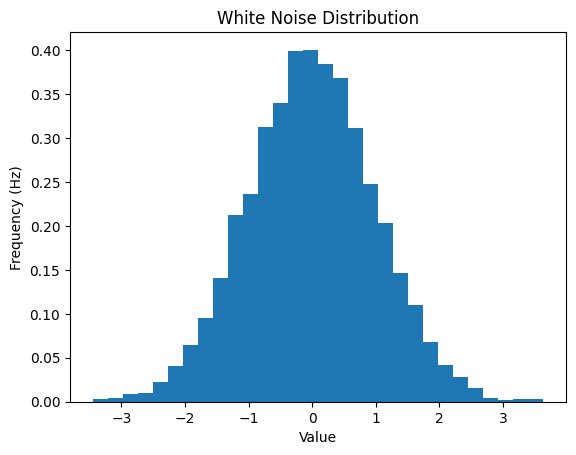

In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

def white_noise(mean, std_dev, num_samples):
    return np.random.normal(mean, std_dev, num_samples)

def plot_white_noise_hist(mean, std_dev, num_samples, bins=30):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Plot noise histogram
    plt.figure()
    plt.hist(noise, bins, density=True)
    plt.title('White Noise Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_white_noise_hist(0, 1, 10000)

This can be transformed into a histogram to show what a signal of white noise might look like:

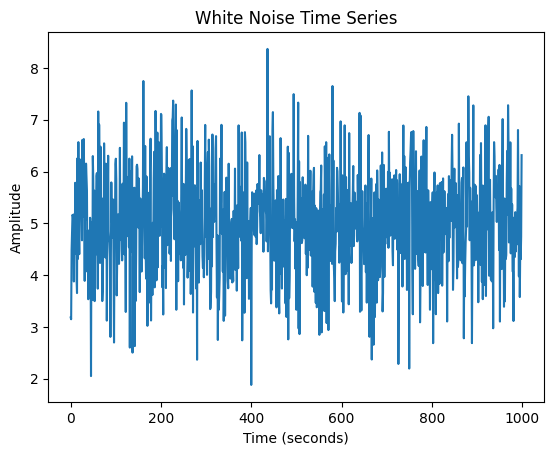

In [2]:
def plot_white_noise_time_series(mean, std_dev, num_samples):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Generate time axis
    time = np.arange(num_samples)

    # Plot noise as a time series
    plt.figure()
    plt.plot(time, noise)
    plt.title('White Noise Time Series')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

plot_white_noise_time_series(5, 1, 1000)

A signal like this can then be converted into a PSD (Power Spectrum Diagram), which shows how powerful different frequencies are in the signal. Because this is white noise, the signal should be roughly equivalently powerful across different frequencies.

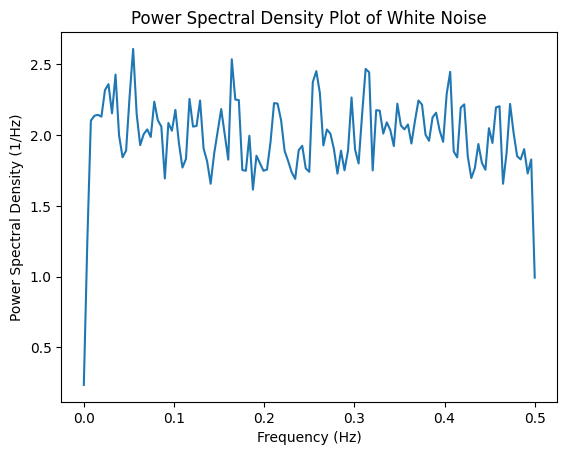

In [3]:
def plot_white_noise_psd(mean, std_dev, num_samples):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Apply Welch's Method
    (frequencies, psds) = signal.welch(noise)

    # Plot PSD graph
    plt.figure()
    plt.plot(frequencies, psds)
    plt.title('Power Spectral Density Plot of White Noise')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power Spectral Density (1/Hz)')
    plt.show()

plot_white_noise_psd(5, 1, 10000)

## Frequency-dependent noise

In real gravitational wave detectors, noise is frequency-dependent. Some noise might be white, but other factors influence the noise in particular ways. For example, seismic waves cause large amounts of noise at low frequencies. When taking a time-series of frequency-dependent noise in a gravitational wave detector, it might look like its completely random:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


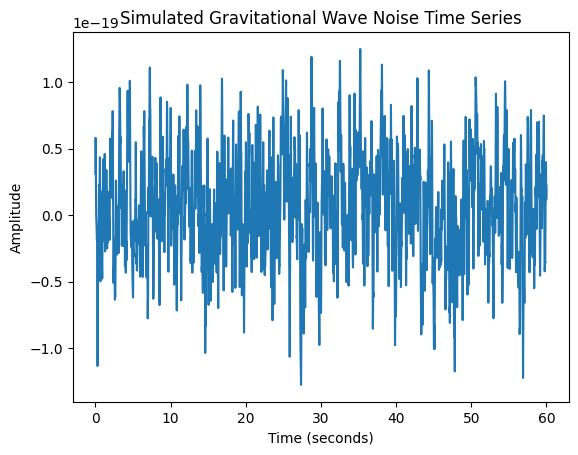

In [4]:
def noise_curvify(input):
    result = []
    for x in input:
        result.append(
            (3.63*10**-22)*((0.3*(x/40)**-6)**2 + (0.3*(x/40)**(-1))**2 + (0.1*(x/120)**0.5)**2)**(1/2)
        )
    return result

def get_freq_dependent_time_series():
    inputs = np.logspace(1, 3.47, 10000)
    noise = white_noise(0, 1, 10000)
    noise_sd = fft(noise)
    curve = noise_curvify(inputs) * noise_sd
    return ifft(curve)

plt.figure()
plt.plot(np.linspace(0, 60, 10000), get_freq_dependent_time_series())
plt.title('Simulated Gravitational Wave Noise Time Series')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


But, when transformed into a PSD, one can see that it is frequency-dependent, leading to curves similar to that shown here:

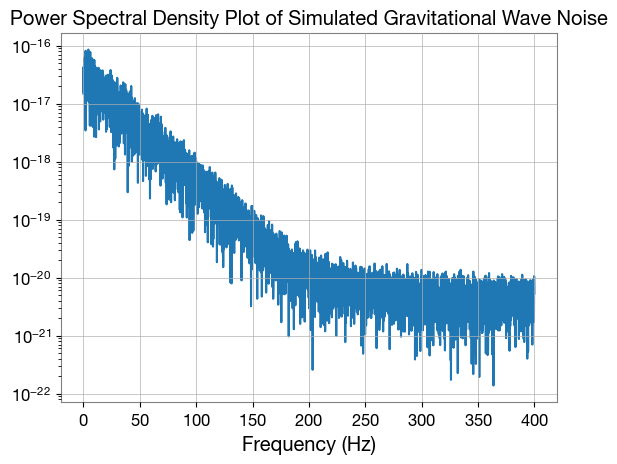

In [11]:
from scipy.fft import fftfreq

time_series = get_freq_dependent_time_series()
yf = fft(time_series)
xf = fftfreq(10000, 1/800)[0:10000//2]
plt.figure()
plt.semilogy(xf, np.abs(yf[0:10000//2]))
plt.title('Power Spectral Density Plot of Simulated Gravitational Wave Noise')
plt.xlabel('Frequency (Hz)')
plt.show()

## Real GWOSC data

Real data can be obtained from GWOSC using the `gwpy` library. Getting data is easy, and can be done using the `TimeSeries.fetch_open_data()` method:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


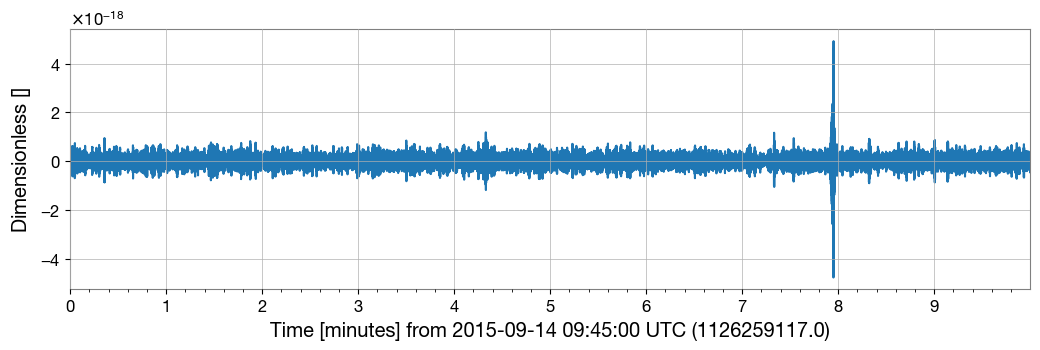

In [6]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

detector_data = TimeSeries.fetch_open_data('H1', 1126259117, 1126259717)

def plot_real_sample_time_series():
    ldata = detector_data
    ldata.plot().show()

plot_real_sample_time_series()

The time series can also be converted into a PSD:

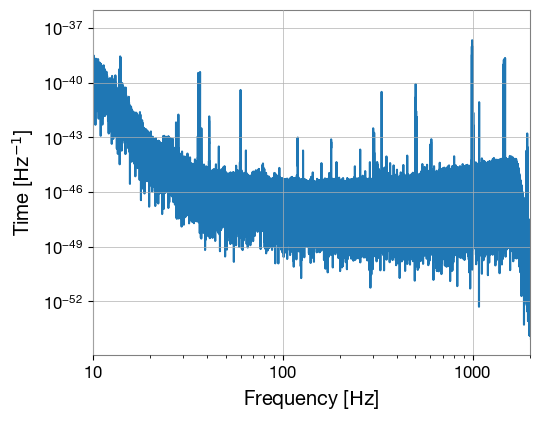

In [7]:
def plot_real_sample_psd():
    ldata = detector_data
    psd = ldata.psd().plot()
    psd.gca().set_xlim(10, 2000)
    psd.show()

plot_real_sample_psd()

Or an ASD:

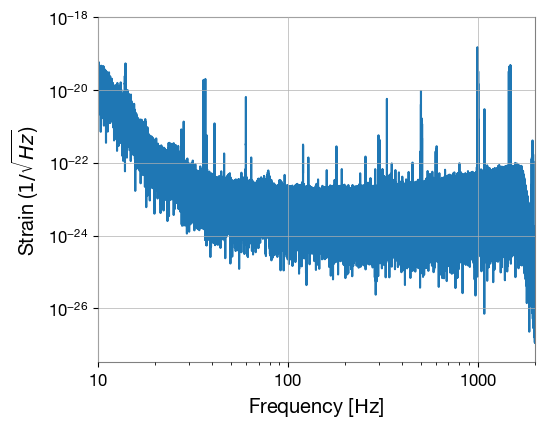

In [8]:
def plot_real_sample_asd():
    data = detector_data
    asd = data.asd().plot(ylabel=r'Strain ($1/\sqrt{Hz}$)')
    asd.gca().set_xlim(10, 2000)
    asd.show()

plot_real_sample_asd()

You can also plot a spectrogram:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


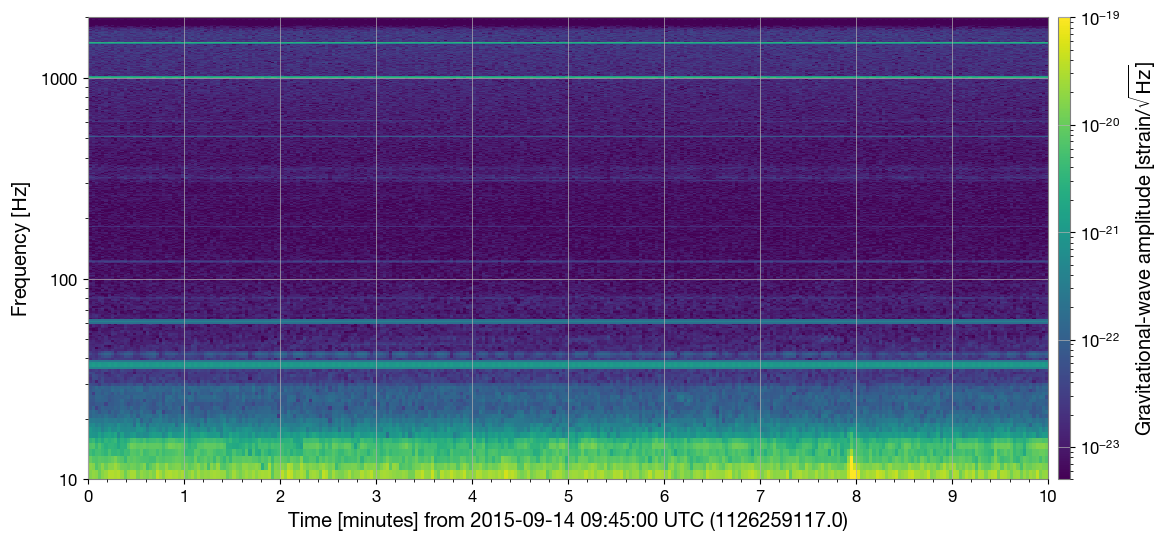

In [9]:
def plot_real_sample_spectrogram():
    data = detector_data
    spectrogram = data.spectrogram(2, fftlength=1, overlap=0.5) ** 0.5

    plot = spectrogram.imshow(norm='log', vmin=5e-24, vmax=1e-19)
    axes = plot.gca()
    axes.set_yscale('log')
    axes.set_ylim(10, 2000)
    axes.colorbar(
        label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]')
    plot.show()

plot_real_sample_spectrogram()